In [5]:
# Similar to evaluate_mix, but plots a comparison between different ML methods on the same plot

import matplotlib
import sys
sys.path.append("/afs/cern.ch/work/m/mgarciam/private/mlpf/")
from src.utils.inference.per_particle_metrics import plot_per_energy_resolution, reco_hist
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import pandas as pd
import mplhep as hep
import os
from src.utils.inference.pandas_helpers import open_hgcal, open_mlpf_dataframe
from src.utils.inference.per_particle_metrics import (
    plot_per_energy_resolution2_multiple, plot_confusion_matrix, plot_confusion_matrix_pandora,
    plot_efficiency_all, calc_unit_circle_dist, plot_per_energy_resolution2, analyze_fakes
)
from src.utils.inference.event_Ks import get_decay_type
import matplotlib.pyplot as plt
import torch
import pickle
hep.style.use("CMS")
# set hep font size

fs = 10
font = {'size': fs}
matplotlib.rc('font', **font)

colors_list = ["#deebf7", "#9ecae1", "#d415bd"]  # color list Jan
all_E = True

neutrals_only = False
log_scale = False
tracks = True
perfect_pid = False   # Pretend we got ideal PID and rescale the momentum vectors accordingly
mass_zero = False    # Set the mass to zero for all particles
ML_pid = True       # Use the PID from the ML classification head (electron/CH/NH/gamma)

# Is there a problem with storing direction information with Pandora?
# /eos/user/g/gkrzmanc/2024/Sept24/Eval_Hss_test_Neutrals_Avg_direction_1file
path = "/eos/home-g/gkrzmanc/results/2024/eval_clustering_plus_model_epoch4_Hss_300files"
if all_E:
    PATH_store = (
        #"/eos/home-g/gkrzmanc/results/2024/eval_clustering_plus_model_epoch4_Hss/model_PID"
       path
    )

    if not os.path.exists(PATH_store):
        os.makedirs(PATH_store)
    PATH_store_individual_plots = os.path.join(PATH_store, "individual_plots")
    PATH_store_detailed_plots = os.path.join(PATH_store, "summary_plots")
    if not os.path.exists(PATH_store_individual_plots):
        os.makedirs(PATH_store_individual_plots)
    if not os.path.exists(PATH_store_detailed_plots):
        os.makedirs(PATH_store_detailed_plots)

    path_list = [
        "showers_df_evaluation/0_0_None_hdbscan.pt"
    ]
    path_pandora = "showers_df_evaluation/0_0_None_pandora.pt"
    dir_top = path
    print(PATH_store)

labels = [
    "ML"
]

def renumber_batch_idx(df):
    # batch_idx has missing numbers
    # renumber it to be like 0,1,2...
    batch_idx = df.number_batch
    unique_batch_idx = np.unique(batch_idx)
    new_to_old_batch_idx = {}
    new_batch_idx = np.zeros(len(batch_idx))
    for idx, i in enumerate(unique_batch_idx):
        new_batch_idx[batch_idx == i] = idx
        new_to_old_batch_idx[idx] = i
    df.number_batch = new_batch_idx
    return df

def filter_df(df):
    # quick filter to exclude problematic particles
    df = df[(df.pid != 11) & (df.pid != 22) ]
    return df

df_list = []
matched_all = {}
for idx, i in enumerate(path_list):
    path_hgcal = os.path.join(dir_top, i)
    sd_hgb, matched_hgb = open_mlpf_dataframe(path_hgcal, neutrals_only)
    #sd_hgb.pred_showers_E = sd_hgb.reco_showers_E
    #print("!!!! Taking the sum of the hits for the energy !!!!")
    # sd_hgb = renumber_batch_idx(sd_hgb[(sd_hgb.pid==22) | (pd.isna(sd_hgb.pid))])
    #sd_hgb.calibrated_E[(~np.isnan(sd_hgb.calibrated_E)) & (sd_hgb.pid==22)] = sd_hgb.pred_showers_E[(~np.isnan(sd_hgb.calibrated_E)) & ((sd_hgb.pid==22))]
    sd_hgb[sd_hgb.pred_pid_matched == 3].calibrated_E = sd_hgb[sd_hgb.pred_pid_matched == 3].pred_showers_E
    # set GT energy for 130, 2112, 22
    #
    ##sd_hgb.calibrated_E[(~np.isnan(sd_hgb.calibrated_E)) & (sd_hgb.pid==130)] = sd_hgb.true_showers_E[(~np.isnan(sd_hgb.calibrated_E)) & ((sd_hgb.pid==130))]
    #sd_hgb.calibrated_E[(~np.isnan(sd_hgb.calibrated_E)) & (sd_hgb.pid==2112)] = sd_hgb.true_showers_E[(~np.isnan(sd_hgb.calibrated_E)) & ((sd_hgb.pid==2112))]
    #sd_hgb.calibrated_E[(~np.isnan(sd_hgb.calibrated_E)) & (sd_hgb.pid==130)] = sd_hgb.pred_showers_E[(~np.isnan(sd_hgb.calibrated_E)) & ((sd_hgb.pid==130))]
    #sd_hgb.calibrated_E[(~np.isnan(sd_hgb.calibrated_E)) & (sd_hgb.pid==2112)] = sd_hgb.pred_showers_E[(~np.isnan(sd_hgb.calibrated_E)) & ((sd_hgb.pid==2112))]
    #sd_hgb.calibrated_E[~np.isnan(sd_hgb.calibrated_E) & (sd_hgb.pred_pid_matched==3)] = sd_hgb.reco_showers_E[~np.isnan(sd_hgb.calibrated_E) & (sd_hgb.pred_pid_matched==3)]
    #sd_hgb.calibrated_E[~np.isnan(sd_hgb.calibrated_E) & (sd_hgb.pred_pid_matched==2)] = sd_hgb.reco_showers_E[~np.isnan(sd_hgb.calibrated_E) & (sd_hgb.pred_pid_matched==3)]
    #sd_hgb.calibrated_E[(~np.isnan(sd_hgb.calibrated_E)) & (sd_hgb.pred_pid_matched==130)] = sd_hgb.reco_showers_E[(~np.isnan(sd_hgb.calibrated_E)) & ((sd_hgb.pid==130))]
    df_list.append(sd_hgb)
    matched_all[labels[idx]] = matched_hgb
sd_pandora, matched_pandora = open_mlpf_dataframe(
    os.path.join(dir_top, path_pandora), neutrals_only
)


/eos/home-g/gkrzmanc/results/2024/eval_clustering_plus_model_epoch4_Hss_300files


/tmp/gkrzmanc/ipykernel_60538/1855101211.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sd_hgb[sd_hgb.pred_pid_matched == 3].calibrated_E = sd_hgb[sd_hgb.pred_pid_matched == 3].pred_showers_E


In [16]:
df = sd_hgb[((sd_hgb.calibrated_E / sd_hgb.true_showers_E) < 0.12 )& (sd_hgb.pid==2112)][["reco_showers_E", "pred_showers_E", "calibrated_E", "true_showers_E", "number_batch"]]

In [17]:
len(df)

361

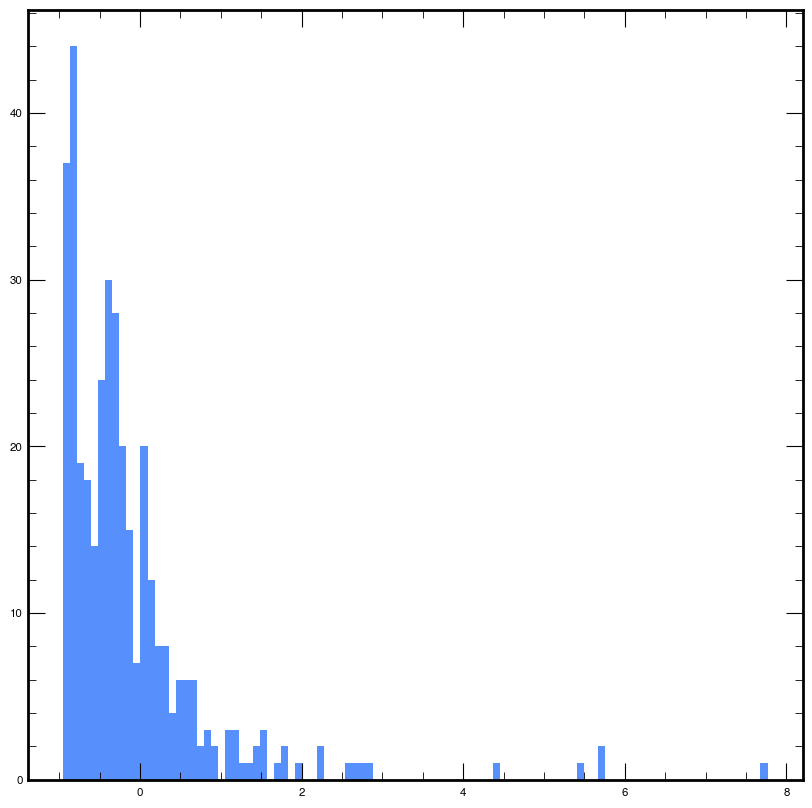

In [18]:
vals = (df.calibrated_E - df.reco_showers_E) / df.reco_showers_E
fig, ax = plt.subplots()
ax.hist(vals, bins=100)
fig.show()

In [19]:
cutoff = 1.0
print(len(df[vals > cutoff]))
df[vals>cutoff]

28


,reco_showers_E,pred_showers_E,calibrated_E,true_showers_E,number_batch
66,0.058854,0.072833,0.147166,1.383615,276.0
20,0.051261,0.075771,0.131529,1.377412,590.0
2,0.019748,0.131651,0.133367,1.155459,1926.0
56,0.036550,0.101189,0.138873,1.312037,3594.0
28,0.054082,0.065446,0.119627,1.270958,4027.0
14,0.050963,0.106586,0.120662,1.223944,5022.0
8,0.058410,0.099829,0.122367,1.316355,5132.0
25,0.033274,0.141718,0.124886,1.300115,6409.0
8,0.032541,0.032541,0.116697,1.190384,9396.0
208,0.050300,0.078718,0.120906,1.248973,9503.0


In [30]:
sd_hgb[(sd_hgb.number_batch == 9503) & ((sd_hgb.pid==2112) | (pd.isna(sd_hgb.pid)))].pred_showers_E.sum() / sd_hgb[(sd_hgb.number_batch == 9503) & ((sd_hgb.pid==2112) | (pd.isna(sd_hgb.pid)))].true_showers_E.sum()

0.66554254

In [29]:
sd_pandora[(sd_pandora.number_batch == 9503) & ((sd_pandora.pid==2112) | (pd.isna(sd_pandora.pid)))].pred_showers_E.sum() / sd_pandora[(sd_pandora.number_batch == 9503) & ((sd_pandora.pid==2112) | (pd.isna(sd_pandora.pid)))].true_showers_E.sum()



0.23416682

In [31]:
 evt = get_response_for_event_energy(
                sd_pandora, sd_hgb, perfect_pid=False, mass_zero=False, ML_pid=True
)

NameError: name 'get_response_for_event_energy' is not defined